## Advanced Lane Finding Project

The goals / steps of this project are the following:
## Advance lane line finding pipeline
1. Camera calibration
2. Make undistorted image
3. Binarize image through color and gradient threshhold
4. Warp undistorted image
5. Use sliding window to find left and right lanes
6. Use buffer history found lanes to smooth the current lanes
7. Caculate the left and right lane curvatures and vehicle offset of the center of the lane
8. Unwarp processed image back and make movie

---
## Define CameraCalibrator class

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle

# store camera calibration parameters in ./camera_cal/calibrated_data.p
CALIBRATED_DATA_FILE = './camera_cal/calibrated_data.p'

class CameraCalibrator:
    def __init__(self, glob_regex, x_corners, y_corners, init_coef=True):
 
        
        # images used for camera calibration
        self.calibration_images = glob_regex
        
        # The number of horizontal corners in calibration images
        self.x_corners = x_corners
        
        # The number of vertical corners in calibration images
        self.y_corners = y_corners
        self.object_points = []
        self.image_points = []
        self.chessboards = []
        self.calibrated_data = {}
        if not init_coef:
            self.calibrate_via_chessboards()

        self.coef_loaded = False
  

    def calibrate_via_chessboards(self):

        object_point = np.zeros((self.x_corners * self.y_corners, 3), np.float32)
        object_point[:,:2] = np.mgrid[0:self.x_corners, 0:self.y_corners].T.reshape(-1, 2)

        for idx, file_name in enumerate(self.calibration_images):
            image = mpimg.imread(file_name)
            gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            ret, corners = cv2.findChessboardCorners(gray_image,(self.x_corners, self.y_corners),None)
            if ret:
                self.object_points.append(object_point)
                self.image_points.append(corners)
                
                # Draw and display the corners
                chessboard_image = np.copy(gray_image)
                cv2.drawChessboardCorners(chessboard_image, (9,6), corners, ret)
                self.chessboards.append(chessboard_image)

        h, w = image.shape[:2]
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(self.object_points, self.image_points, (w, h), None, None)

        self.calibrated_data = {'mtx': mtx, 'dist': dist}

        with open(CALIBRATED_DATA_FILE, 'wb') as f:
            pickle.dump(self.calibrated_data, file=f)

        self.coef_loaded = True

    def undistort(self, image):

        if not os.path.exists(CALIBRATED_DATA_FILE):
            raise Exception('Camera calibration data file does not exist at ' + CALIBRATED_DATA_FILE)

        if not self.coef_loaded:

            with open(CALIBRATED_DATA_FILE, 'rb') as fname:
                self.calibrated_data = pickle.load(file=fname)

            self.coef_loaded = True

        return cv2.undistort(image, self.calibrated_data['mtx'], self.calibrated_data['dist'],None, self.calibrated_data['mtx'])

##  Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
1. Class CameraCalibrator has construntor,calibrate_via_chessboards,and undistort method. 
2. I use cv2.findChessboardCorners to find inner coners in chessboard and use cv2.calibrateCamera to get calibration matix and distortion coefficients.

In [2]:
# Use glob to get a list of calibration images
calibration_images = glob.glob('./camera_cal/calibration*.jpg')

# Here init_coef  set false to call calibrate_via_chessboards() at first time 
# and store  calibration matix and distortion coefficients in './camera_cal/calibrated_data.p'
calibrator = CameraCalibrator(calibration_images, 9, 6, init_coef = False)

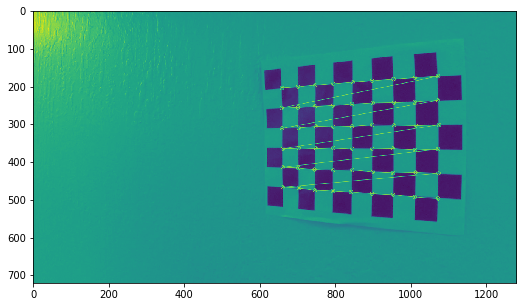

In [3]:
%matplotlib inline
# Display the chessboard with 9X6 corners drawn
plt.figure(figsize=(10,5))
plt.imshow(calibrator.chessboards[2])
plt.show()

## Apply a distortion correction to raw images.

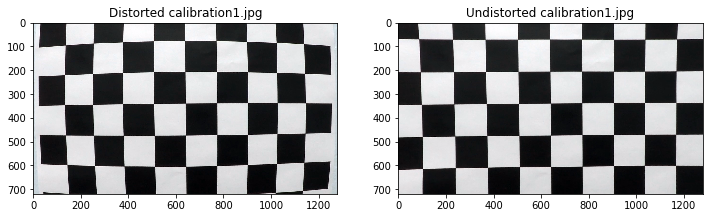

In [4]:
# Take example distorted image and undistort it using saved camera coefficients
distorted_image = './camera_cal/calibration1.jpg'
distorted_image = cv2.imread(distorted_image)
undistorted_image = calibrator.undistort(distorted_image)

# Display both distorted and undistorted images
plt.figure(figsize=(12,7))
plt.subplot(1, 2, 1)
plt.title('Distorted calibration1.jpg')
plt.imshow(distorted_image)

plt.subplot(1, 2, 2)
plt.imshow(undistorted_image)
plt.title('Undistorted calibration1.jpg')

plt.show()

## Apply a perspective transform to warp the image ("birds-eye view").

On test_images/straight_lines2.jpg, I choose the 4 points [277, 670], [582, 457], [703, 457], [1046, 670] to get perspectivet_ransformer; following lines are 4 step pipeline to do it .
1. define 4 source points src = np.float32([[277, 670], [582, 457], [703, 457], [1046, 670]])
2. define 4 destination points dst = np.float32([[277, 670], [277,0], [1046,0], [1046,670]])
3. use cv2.getPerspectiveTransform() to get M, the transform matrix
4. use cv2.warpPerspective() to warp your image to a top-down view

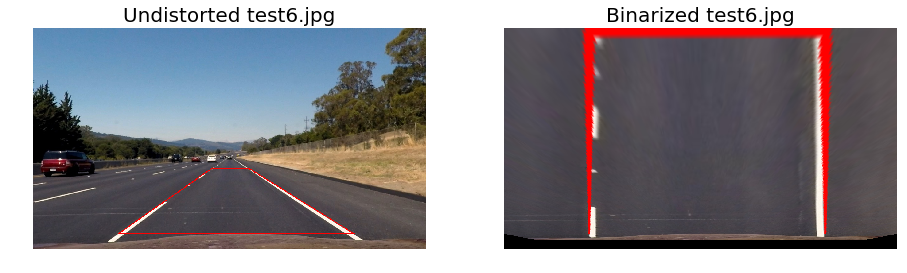

In [5]:
%matplotlib inline
    
def warp(img):

    img_size = (img.shape[1],img.shape[0])
    
    corners = np.float32([[277, 670], [582, 457], [703, 457], [1046, 670]])

    src = np.float32([corners[0], corners[1], corners[2], corners[3]])
    dst = np.float32([[277, 670], [277,0], [1046,0], [1046,670]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

# 
fname = 'test_images/straight_lines2.jpg'
image = mpimg.imread(fname)
undistorted_image = calibrator.undistort(image)
cv2.imwrite('test_images/straight_lines2_undistorted.png',undistorted_image, [int( cv2.IMWRITE_JPEG_QUALITY), 95])

# Choose  
pts = np.array([[277, 670], [582, 457], [703, 457], [1046, 670]], np.int32)
pts = pts.reshape((-1,1,2))
imd = np.copy(undistorted_image)
imd = cv2.polylines(imd,[pts],True,(255,0,0),2)

binary_warped, perspective_M, Minv  = warp(imd)

plt.figure(figsize=(12, 7))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Undistorted test6.jpg' ,fontsize=20)
plt.imshow(imd)

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Binarized test6.jpg', fontsize=20)
plt.imshow(binary_warped,cmap='gray')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## Use color transforms, gradients, etc., to create a thresholded binary image.
We use the following two threshhold binary filters:
1. Apply Sobel operator in X direction
2. Convert image to HLS color space, and use the L and S channel threshhold to filter cause HLS scheme is more reliable when it comes to find out lane lines

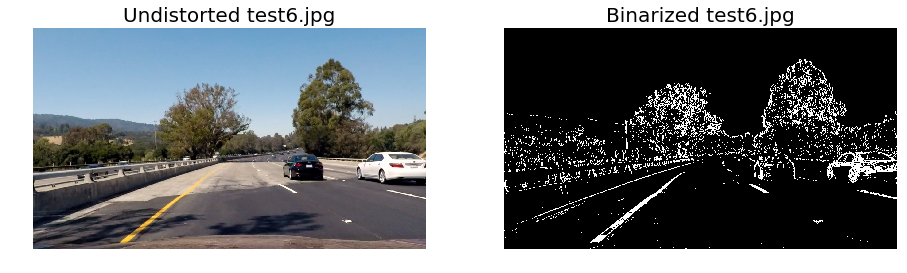

In [6]:
%matplotlib inline

# This method is used to reduce the noise of binary images.
def noise_reduction(image, threshold=4):
    k = np.array([[1, 1, 1],
                  [1, 0, 1],
                  [1, 1, 1]])
    nb_neighbours = cv2.filter2D(image, ddepth=-1, kernel=k)
    image[nb_neighbours < threshold] = 0
    return image

def binary_threshold_filter(channel, thresh = (200, 255), on = 1):
    binary = np.zeros_like(channel)
    binary[(channel > thresh[0]) & (channel <= thresh[1])] = on
    return binary
    
def binary_pipeline(image, 
					hls_s_thresh = (170,255),
					hls_l_thresh = (30,255),
					hls_h_thresh = (15,100),
					sobel_thresh=(20,255),
					mag_thresh=(70,100),
					dir_thresh=(0.8,0.9),
					r_thresh=(150,255),
					u_thresh=(140,180),
					sobel_kernel=3):

    # Make a copy of the source iamge
    image_copy = np.copy(image)

    gray = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)

    r_thresh = (150,255)
	# RGB colour
    R = image_copy[:,:,0]
    G = image_copy[:,:,1]
    B = image_copy[:,:,2]
    rbinary = binary_threshold_filter(R, r_thresh)
    
    u_thresh = (140,180)
    # YUV colour
    yuv = cv2.cvtColor(image_copy, cv2.COLOR_RGB2YUV)
    Y = yuv[:,:,0]
    U = yuv[:,:,1]
    V = yuv[:,:,2]
    ubinary = binary_threshold_filter(U, u_thresh)

    # Convert RGB image to HLS color space.
    # HLS more reliable when it comes to find out lane lines
    hls = cv2.cvtColor(image_copy, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]
    l_channel = hls[:, :, 1]
    h_channel = hls[:, :, 0]
    # We generated a binary image using S component of our HLS color scheme and provided S,L,H threshold
    s_binary = binary_threshold_filter(s_channel,hls_s_thresh)
    l_binary = binary_threshold_filter(l_channel,hls_l_thresh)
    h_binary = binary_threshold_filter(h_channel,hls_h_thresh)

    # We apply Sobel operator in X,Y direction and calculate scaled derivatives.
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    sxbinary = binary_threshold_filter(scaled_sobel,sobel_thresh)

    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobely = np.absolute(sobely)
    scaled_sobel = np.uint8(255 * abs_sobely / np.max(abs_sobely))
    sybinary = binary_threshold_filter(scaled_sobel,sobel_thresh)

    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    mag_binary = binary_threshold_filter(gradmag, mag_thresh)

    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary = binary_threshold_filter(absgraddir, dir_thresh)

    # Return the combined binary image
    binary = np.zeros_like(sxbinary)
    binary[(((l_binary == 1) & (s_binary == 1) | (sxbinary == 1)) ) ] = 1
    binary = 255 * np.dstack((binary, binary, binary)).astype('uint8')

    return noise_reduction(binary)
                           
# Use distortion image
fname = 'test_images/test4.jpg'
img_shadow = mpimg.imread(fname)
undistorted_shadow = calibrator.undistort(img_shadow)
combined_binary_shadow = binary_pipeline(undistorted_shadow)

plt.figure(figsize=(12, 7))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Undistorted test6.jpg' ,fontsize=20)
plt.imshow(undistorted_shadow)

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Binarized test6.jpg', fontsize=20)
plt.imshow(combined_binary_shadow)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## Warp distorted birarized image

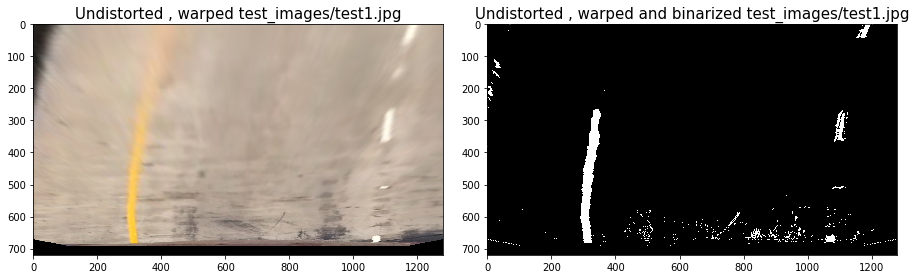

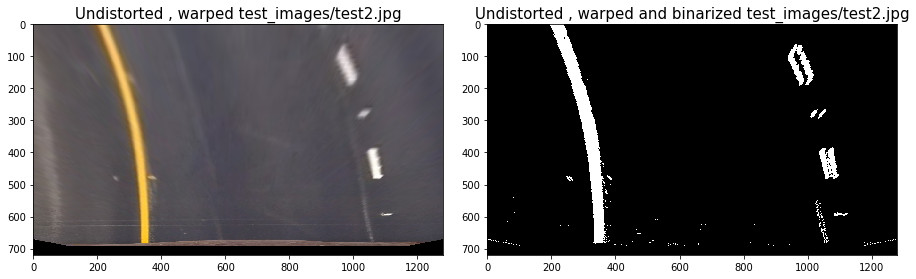

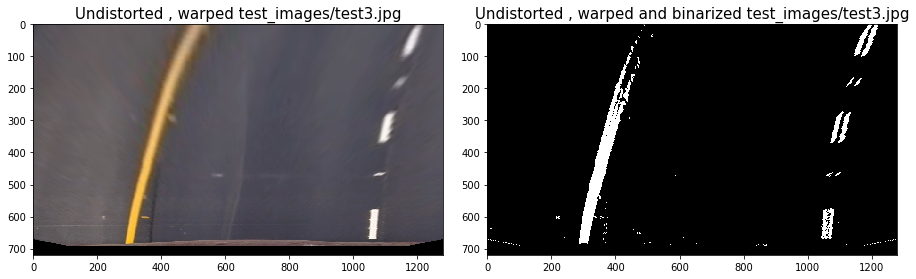

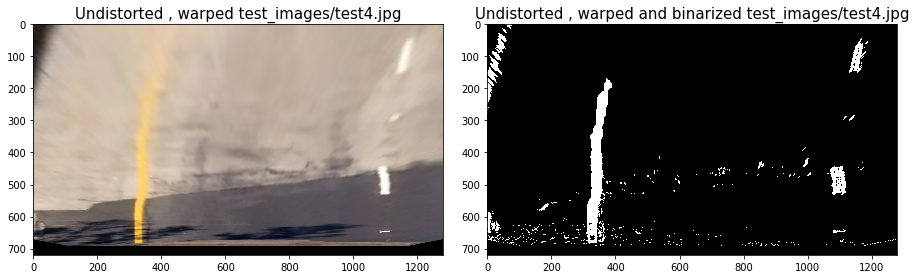

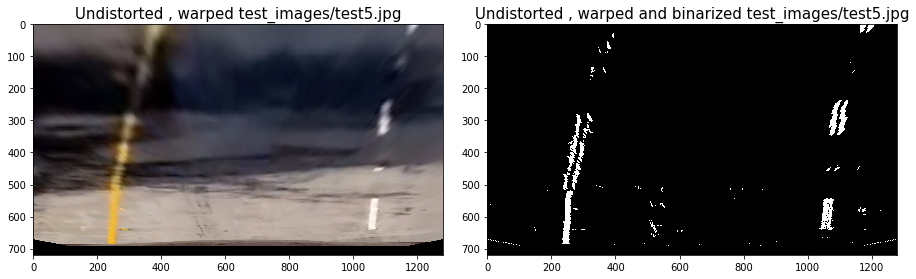

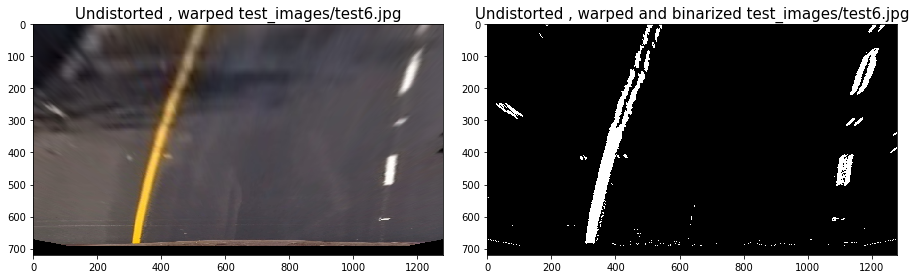

In [7]:
binary_images = []
for i in range(1,7):
    
    fname = 'test_images/test'+str(i)+'.jpg'
    img = mpimg.imread(fname)
    undistorted = calibrator.undistort(img)
    undistorted_unwarped, _, _ = warp(undistorted)
    combined_binary = binary_pipeline(undistorted_unwarped)
    img_size = (undistorted.shape[1],undistorted.shape[0])

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
    f.tight_layout()
    ax1.imshow(undistorted_unwarped)
    ax1.set_title('Undistorted , warped ' + fname, fontsize=15)
    ax2.imshow(combined_binary)
    ax2.set_title('Undistorted , warped and binarized '+ fname, fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    binary_images.append(combined_binary)

## Use sliding window to find left and right lanes

(720, 1280, 3)


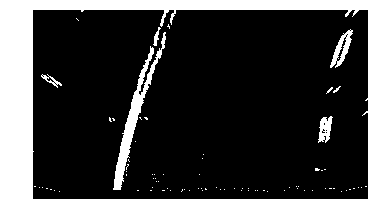

In [8]:
# Choose test6.jpg to do experiment
warped_image = binary_images[5] 
print(warped_image.shape)
plt.imshow(warped_image)
plt.axis('off')
plt.show()

### Use histogram of pixels to find the bottm point of left and right lane lines of image

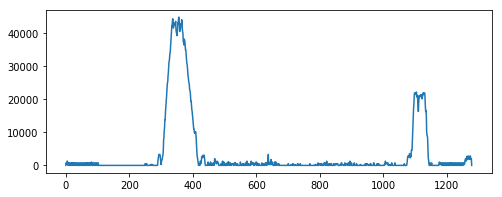

In [9]:
#Bottom half region of image  of 0 channel
histogram = np.sum(warped_image[warped_image.shape[0] // 2:, :, 0], axis=0)
plt.figure(figsize=(8, 3))
plt.plot(histogram)
plt.show()

In [10]:
# get midpoint of the histogram  == half of width
midpoint = np.int(histogram.shape[0] / 2)

# get left and right half points of the histogram
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

print('Peak point of left half: {}'.format(leftx_base))
print('Peak point of right half: {}'.format(rightx_base))

Peak point of left half: 356
Peak point of right half: 1104


### Detect lane line pixels and fit to lane curve

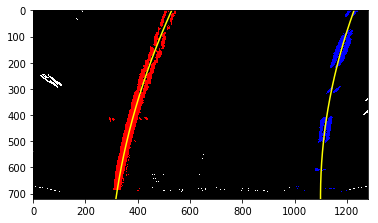

In [11]:
# Choose the number of sliding windows
nwindows = 9

# Set height of sliding window
window_height = np.int(warped_image.shape[0] / nwindows)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = warped_image.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Set the width of the windows +/- margin
margin = 100

# Set minimum number of pixels found to recenter window
min_num_pixels = 50

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

for window in range(nwindows):
    
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped_image.shape[0] - (window + 1) * window_height
    win_y_high = warped_image.shape[0] - window * window_height

    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin

    # Search pixels in sliding windows
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                      (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                       (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)

    if len(good_left_inds) > min_num_pixels:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > min_num_pixels:
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the ndarrays of indices
left_lane_array = np.concatenate(left_lane_inds)
right_lane_array = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_array]
lefty = nonzeroy[left_lane_array]
rightx = nonzerox[right_lane_array]
righty = nonzeroy[right_lane_array]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, warped_image.shape[0] - 1, warped_image.shape[0])
fit_leftx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
fit_rightx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]


warped_image[nonzeroy[left_lane_array], nonzerox[left_lane_array]] = [255, 0, 0]
warped_image[nonzeroy[right_lane_array], nonzerox[right_lane_array]] = [0, 0, 255]
plt.imshow(warped_image)
plt.plot(fit_leftx, ploty, color='yellow')
plt.plot(fit_rightx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

### Polyfill the found left and right lanes and unwarp onto original distorted image 

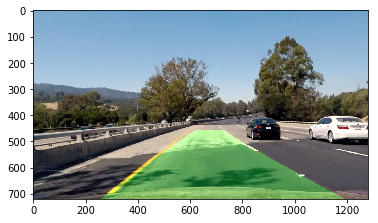

In [13]:
fname = 'test_images/test4.jpg'
img = mpimg.imread(fname)
image_size = img.shape
undistorted = calibrator.undistort(img)
undistorted_unwarped, _, _ = warp(undistorted)
binary_warped = binary_pipeline(undistorted_unwarped)
    
# Create an image to draw the lines on
warp_zero = np.zeros_like(undistorted)
fit_y = np.linspace(0, warp_zero.shape[0] - 1, warp_zero.shape[0])


# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([fit_leftx, fit_y]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([fit_rightx, fit_y])))])

pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(warp_zero, Minv, (undistorted.shape[1], undistorted.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
plt.imshow(result)

## Measuring Curvature

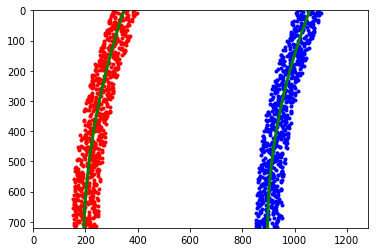

In [14]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

##  calculate the radius of curvature in pixels

In [15]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print('Left lane curvature( in pixel) : ',left_curverad)
print('Right lane curvature( in pixel) : ',right_curverad)

Left lane curvature( in pixel) :  2109.75707879
Right lane curvature( in pixel) :  1658.64425009


### Calculation of radius of curvature after correcting for scale in x and y

In [16]:
# f(y)= A*power(y,2)+B*y+C
# y= image_size[0]  ==> f(y) = intersection points at the bottom of our imag
left_intercept = left_fit[0] * img_size[0] ** 2 + left_fit[1] * img_size[0] + left_fit[2]
right_intercept = right_fit[0] * img_size[0] ** 2 + right_fit[1] * img_size[0] + right_fit[2]

# Caculate the distance in pixels between left and right intersection points
road_width_in_pixels = right_intercept - left_intercept
print('pixels between left and right intersection points ',road_width_in_pixels)

# Since average highway lane line width in US is about 3.7m
# Assume lane is about 30 meters long and 3.7 meters wide
# we calculate length per pixel and ensure "order of magnitude" correct
xm_per_pix = 3.7 / road_width_in_pixels
ym_per_pix = 30 / image_size[0]

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

# Now our radius of curvature is in meters
print('Left lane curvature( in metes) : ',left_curverad,' m')
print('Right lane curvature( in meters) : ',right_curverad,' m')

# lane deviation
calculated_center = (left_intercept + right_intercept) / 2.0
lane_deviation = (calculated_center - img_size[1] / 2.0) * xm_per_pix
print('lain deviation ',lane_deviation,'m')

pixels between left and right intersection points  742.343647644
Left lane curvature( in metes) :  732.95357818  m
Right lane curvature( in meters) :  577.694651436  m
lain deviation  1.2773233819 m


### Sanity Check

In [17]:
# Here means something wrong with lane finding 
assert road_width_in_pixels > 0, 'Road width in pixel must be positive!!'

## Use buffer history found lanes to smooth the current lanes
I use a buffer in Line class to store the previous found 10 lane lines and use the median value of buffers as the unwarp ones. See line 431 ~ line 438 in code file 'Advanced_Lane_Finding.py'

## Unwarp processed image back and make movie

I create **class Line** in file **Advanced_Lane_Finding.py** to include all the methods we discussed above;
The key method **image_process_pipeline** take parameter image to which implement the following pipeline:
1. Make undistorted image
2. Warp undistorted image
3. Binarize image through color and gradient threshhold
4. Use sliding window to find left and right lanes
5. Use buffer history found lanes to smooth the current lanes
6. Caculate the left and right lane curvatures and vehicle offset of the center of the lane
7. Unwarp processed image back and display

In [18]:
from moviepy.editor import VideoFileClip
from Advanced_Lane_Finding import *

line = Line()
input_file = './project_video.mp4'
output_file = './processed_project_video.mp4'
clip = VideoFileClip(input_file)
out_clip = clip.fl_image(line.image_process_pipeline)
out_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video ./processed_project_video.mp4
[MoviePy] Writing video ./processed_project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:51<00:00,  3.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./processed_project_video.mp4 



In [20]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file))